In [1]:
# 为了测试图片的像素数量是否和网络的性能有关，我有两个思路，一个是使用参数更小的网络，一个是使用更大的图片
# 这里我使用了更大的图片进行处理
import os
current_path = os.getcwd()
print(current_path)
os.chdir("..")
current_path = os.getcwd()
print(current_path)

/home/xzhang/Documents/我的模型/experiments
/home/xzhang/Documents/我的模型


In [2]:
# 模型相关
import torch
from models.DIP_2D import DIP_2D
import pytorch_lightning as pl
import numpy as np
from numpy import random

# 画图相关
import matplotlib.pyplot as plt

# 文件读写相关
from config.config import *
import pandas as pd
import csv
from PIL import Image

# 自定义函数
from utils.pre_utils import *

from functools import partial
import datetime

/home/xzhang/miniconda3/envs/dip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/xzhang/miniconda3/envs/dip/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(96, 96) 400.0
(384, 384)


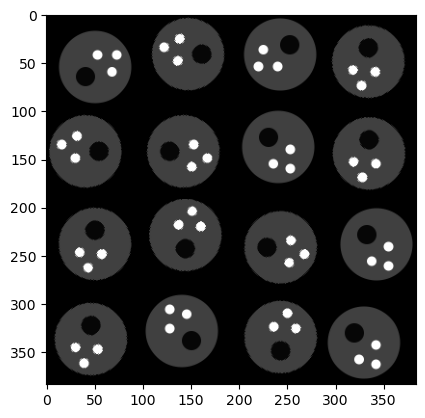

In [3]:
# 图片预处理
corrupted_image_path = "data/corrupted_images/BSREM_it30.npy"
ground_truth_path = 'data/ground_truth/ground_truth.npy'
# 加载原始图像，这里假设原始图像已经保存成numpy array的形式
corrupted_image= np.squeeze(np.load(corrupted_image_path))
ground_truth = np.squeeze(np.load(ground_truth_path))
# 复制图片，得到一个大小为（8，112，112，1）的数组，8表示要复制的次数，1, 1, 1表示在三个维度上不进行复制，即将原始图像在第一个维度上复制8次，其余维度不变。image_copies数组的形状为(8, 112, 112, 1)，表示复制了8张大小为112*112*1的图片。
corrupted_image_copie = np.tile(corrupted_image, (16, 1, 1))
ground_truth_copie = np.tile(ground_truth, (16, 1, 1))
corrupted_image_copies = list(range(16))
ground_truth_copies =list(range(16))
# 定义裁剪大小
crop_size = 96

# 遍历所有的图片，对每一张进行随机裁剪
cropped_images = []
for i in range(16):
    # 随机生成裁剪位置
    h, w = corrupted_image.shape[0], corrupted_image.shape[1]
    top = np.random.randint(0, h - crop_size)
    left = np.random.randint(0, w - crop_size)
    corrupted_image_copies[i] = corrupted_image_copie[i][top:top+crop_size, left:left+crop_size]
    ground_truth_copies[i] = ground_truth_copie[i][top:top+crop_size, left:left+crop_size]
    print(corrupted_image_copies[i].shape,ground_truth_copies[i].max())

# 定义旋转角度
angles = [0, 45, 90, 135, 180, 225, 270, 315]

# 遍历所有的裁剪后的图片，对每一张进行随机旋转
rotated_images = []
for i in range(16):
    # 随机生成旋转角度
    angle = random.choice(angles)
    # 进行旋转
    corrupted_image_copies[i]= np.array(Image.fromarray(corrupted_image_copies[i]).rotate(angle))
    ground_truth_copies[i]= np.array(Image.fromarray(ground_truth_copies[i]).rotate(angle))

# 拼接图像，得到一个大小为（448，448，1）的大图像
corrupted_image_concatenated = np.concatenate([np.concatenate(corrupted_image_copies[:4], axis=1), np.concatenate(corrupted_image_copies[4:8], axis=1),
                                               np.concatenate(corrupted_image_copies[8:12], axis=1),np.concatenate(corrupted_image_copies[12:16], axis=1)], axis=0)
ground_truth_concatenated = np.concatenate([np.concatenate(ground_truth_copies[:4], axis=1), np.concatenate(ground_truth_copies[4:8], axis=1),
                                               np.concatenate(ground_truth_copies[8:12], axis=1),np.concatenate(ground_truth_copies[12:16], axis=1)], axis=0)
print(ground_truth_concatenated.shape)
np.save("data/corrupted_images/corrupted_image_concatenated.npy",corrupted_image_concatenated)
np.save( 'data/ground_truth/ground_truth_concatenated.npy', ground_truth_concatenated)
plt.imshow(ground_truth_concatenated,cmap='gray')
plt.show()

In [4]:
path_input = "data/noisy_images/uniform_noise3.npy"
path_ground_truth = "data/ground_truth/ground_truth_concatenated.npy"
path_target = "data/corrupted_images/corrupted_image_concatenated.npy"

In [5]:
# 跑模型并可视化结果

image_net_input = np.load(path_input)

# image_net_input_scale,param1_scale_im_net,param2_scale_im_net = rescale_imag(image_net_input,"standardization") 
# image_net_input_torch = torch.Tensor(image_net_input_scale)

image_net_input_torch = torch.Tensor(image_net_input)
image_net_input_torch = image_net_input_torch.view(1,1,384,384)


ground_truth = np.load(path_ground_truth)

image_corrupt = np.load(path_target)
image_corrupt_input_scaled,param1_scale_im_corrupt,param2_scale_im_corrupt = rescale_imag(image_corrupt,"standardization") # 标准化图片, 减去平均值，除以标准差，参数1是mean，参数2是std
image_corrupt_torch = torch.Tensor(image_corrupt_input_scaled)
image_corrupt_torch = image_corrupt_torch.view(1,1,384,384)


plt.imshow(ground_truth, cmap='gray')
plt.show()  

KeyboardInterrupt: 

In [ ]:
def add_noise(data):
    

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/xzhang/miniconda3/envs/dip/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1292: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(

   | Name       | Type       | Params
-------------------------------------------
0  | deep1      | Sequential | 2.5 K 
1  | down1      | Sequential | 2.4 K 
2  | deep2      | Sequential | 14.0 K
3  | down2      | Sequential | 9.3 K 
4  | deep3      | Sequential | 55.7 K
5  | down3      | Sequential | 37.1 K
6  | deep4      | Sequential | 221 K 
7  | up1        | Sequential | 73.9 K
8  | deep5      | Sequential | 74.1 K
9  | up2        | Sequential | 18.5 K
10 | deep6      | Sequential | 18.6 K
11 | up3        | Sequential | 4.7 K 
12 | deep7      | Sequential | 2.5 K 
13 | positivity | ReLU       | 0     
--------------------------------------

Number of params: 535251
Epoch 0:   0%|          | 0/1 [00:00<00:00, 846.31it/s]   

/home/xzhang/miniconda3/envs/dip/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([384, 384])) that is different to the input size (torch.Size([1, 1, 384, 384])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 499:   0%|          | 0/1 [00:00<00:00, 1142.24it/s, loss=0.0714, v_num=0] 0
Succesfully save in: data/output_images/output_aaa_499.img
Epoch 999:   0%|          | 0/1 [00:00<00:00, 825.00it/s, loss=0.0329, v_num=0]  0
Succesfully save in: data/output_images/output_aaa_999.img
Epoch 1499:   0%|          | 0/1 [00:00<00:00, 1026.76it/s, loss=0.0242, v_num=0] 0
Succesfully save in: data/output_images/output_aaa_1499.img
Epoch 1999:   0%|          | 0/1 [00:00<00:00, 930.00it/s, loss=0.0168, v_num=0]  0
Succesfully save in: data/output_images/output_aaa_1999.img
Epoch 2499:   0%|          | 0/1 [00:00<00:00, 861.61it/s, loss=0.0137, v_num=0]  0
Succesfully save in: data/output_images/output_aaa_2499.img
Epoch 2999:   0%|          | 0/1 [00:00<00:00, 806.91it/s, loss=0.0113, v_num=0]  0
Succesfully save in: data/output_images/output_aaa_2999.img
Epoch 3499:   0%|          | 0/1 [00:00<00:00, 797.70it/s, loss=0.00914, v_num=0]  0
Succesfully save in: data/output_images/output_aaa_3499

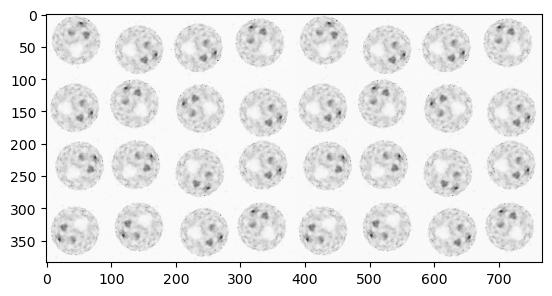

In [ ]:

 # 加载数据
train_dataset = torch.utils.data.TensorDataset(image_net_input_torch,image_corrupt_torch)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1) 

# 加载模型
model = DIP_2D(param1_scale_im_corrupt, param2_scale_im_corrupt, config,'data/Algo/',
            "nested",all_images_DIP="False",global_it=-100, suffix='aaa',last_iter=-1,ground_truth=ground_truth,target=image_corrupt,initial_param='kaiming_norm')
# model.init_weights()
model_class = DIP_2D

#定义tensorboard
checkpoint_simple_path = os.getcwd() + '/test5_logs'
# experiment = 24
name=str(datetime.datetime.now())

logger = pl.loggers.TensorBoardLogger(save_dir=checkpoint_simple_path,name=name)#version=format(experiment), name=name)
trainer = pl.Trainer(max_epochs=config["sub_iter_DIP"],log_every_n_steps=1,logger=logger)#, callbacks=[checkpoint_callback, tuning_callback, early_stopping_callback], logger=logger,gpus=gpus, accelerator=accelerator, profiler="simple")

# 训练模型
trainer.fit(model, train_dataloader)
out = model(image_net_input_torch)

image_out = out.view(384,384).detach().numpy()
image_concat = np.concatenate((image_corrupt, destand_numpy_imag(image_out,param1_scale_im_corrupt,param2_scale_im_corrupt)), axis=1)
image_reversed =np.max(image_concat)-image_concat

plt.imshow(image_reversed, cmap='gray')
plt.show()  